In this notebook we develop the initial neural network in pytorch and some data for it. 

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Part I - Simple data

We try and get PyTorch to return the gradients for some simple data.

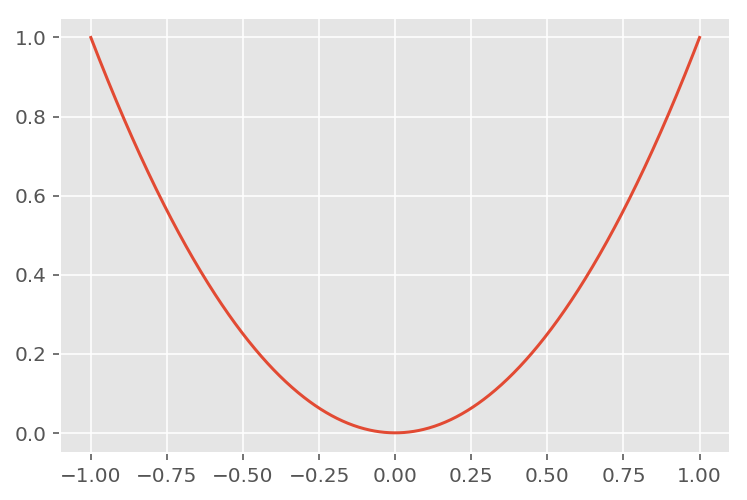

In [55]:
x = np.linspace(-1,1,1000)
y = x**2

plt.plot(x,y)
plt.show()

In [56]:
X_pt = torch.autograd.Variable(torch.FloatTensor(np.expand_dims(x,1)),requires_grad=True)
y_pt = torch.FloatTensor(np.expand_dims(y,1))

In [57]:
model = torch.nn.Sequential(torch.nn.Linear(1,10),
                            torch.nn.Tanhshrink(),
                            torch.nn.Linear(10,10),
                            torch.nn.Tanhshrink(),
                            torch.nn.Linear(10,1))

In [58]:
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [61]:
steps=0
for i in np.arange(steps):
    y_pred = model(X_pt)

    loss = loss_fn(y_pred, y_pt)
    if i%10000==0:
        print(i, loss.item())
  
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

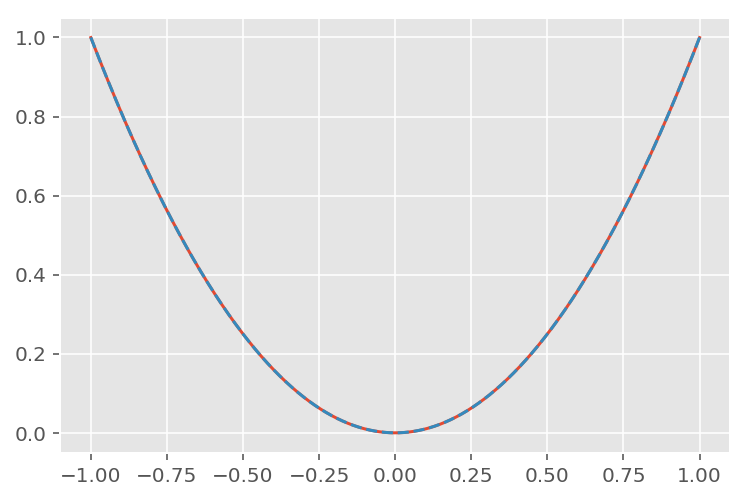

In [8]:
plt.plot(X_pt.detach().numpy(),model(X_pt).detach().numpy())
plt.plot(x,y,'--')

In [51]:
X_pt.grad.data.zero_()
y_pred.backward(torch.ones_like(y_pred),create_graph=True, retain_graph=True)
dx=X_pt.grad

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

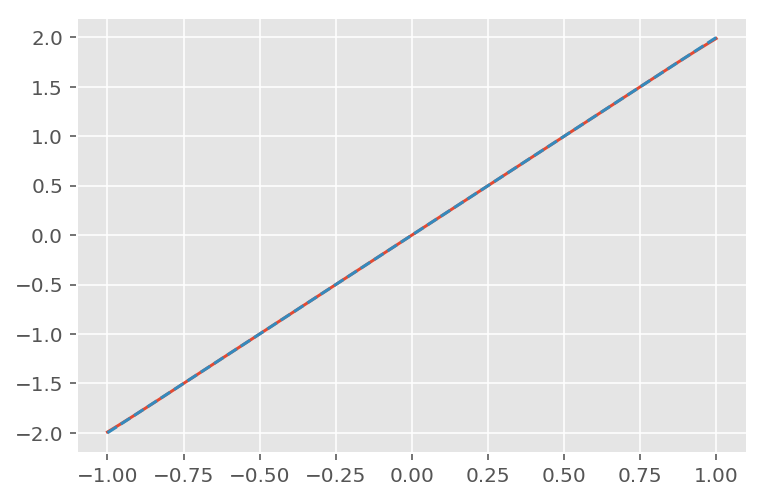

In [46]:
plt.plot(x,dx.detach().numpy())
plt.plot(x,2*x,'--')

In [49]:
X_pt.grad.data.zero_()
dx.backward(torch.ones_like(dx))
dx2=X_pt.grad

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

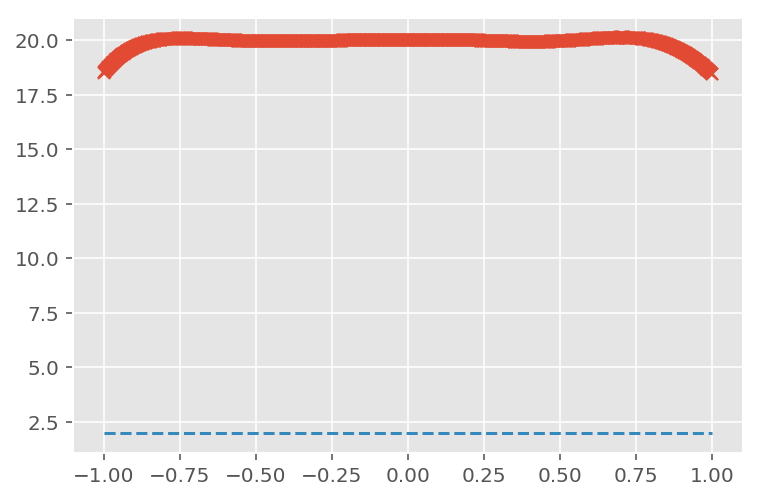

In [48]:
plt.plot(x,dx2.detach().numpy(),'x')
plt.plot(x,2*np.ones_like(x),'--')

In [43]:
X_pt.grad.data.zero_()
y_pred.backward(torch.ones_like(y_pred),retain_graph=True,create_graph=True)
dydx=X_pt.grad
dydx.backward(torch.ones_like(dydx),retain_graph=True)
dx2=X_pt.grad

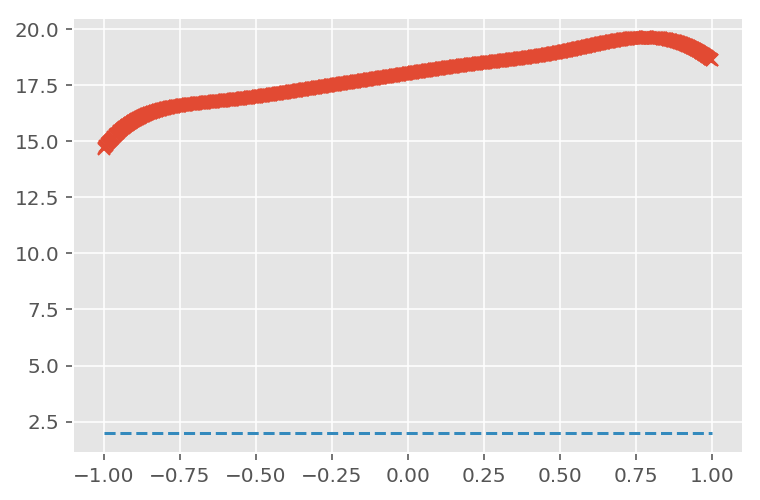

In [44]:
plt.plot(x,dx2.detach().numpy(),'x')
plt.plot(x,2*np.ones_like(x),'--')

In [28]:
%reset_selective dx dx2

Once deleted, variables cannot be recovered. Proceed (y/[n])?   y


In [60]:
x[0]-x[1]

-0.002002002002001957

In [37]:
dx.detach().numpy().flatten().shape

(1000,)

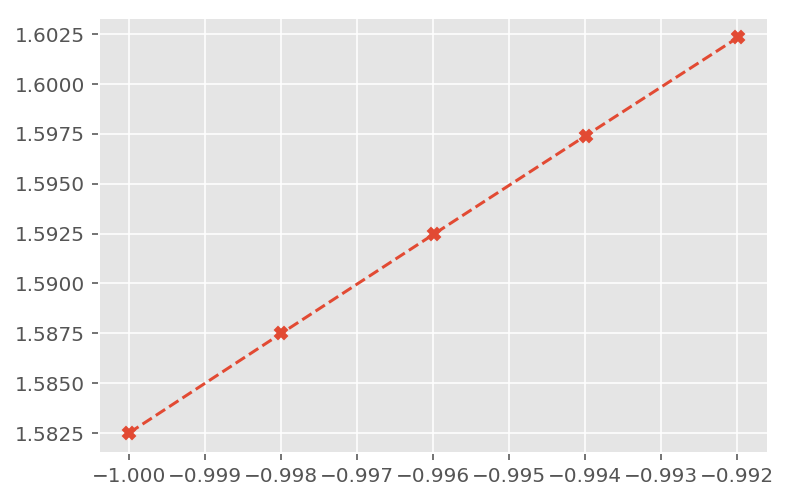

In [38]:
plt.plot(x[:5],dx.detach().numpy().flatten()[:5],'X--')

array([1.5748472, 1.5796704, 1.5890784, 1.598427 , 1.6077161, 1.6166776,
       1.6257583, 1.6346602, 1.643324 , 1.6477304], dtype=float32)

In [112]:
X_pt.grad.data.zero_()
dx2.backward(torch.ones_like(dx2),retain_graph=True)
dx3 = X_pt.grad

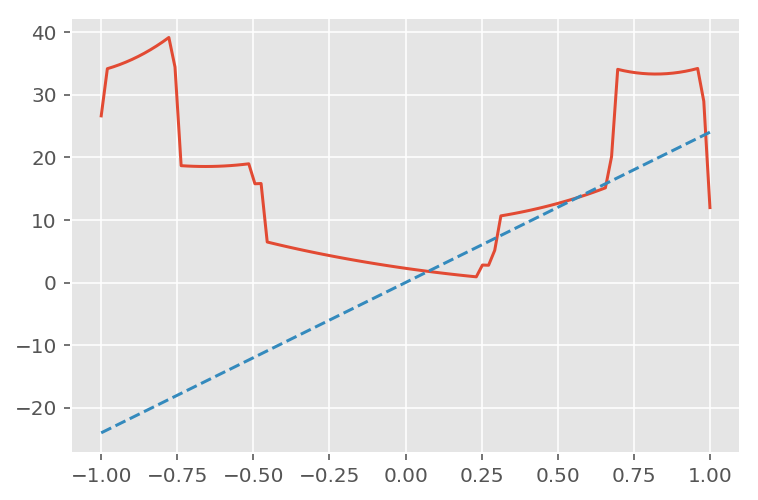

In [192]:
plt.plot(x,dx3.detach().numpy())
plt.plot(x,24*x,'--')

In [124]:
x = torch.autograd.Variable(torch.FloatTensor(np.ones((5,2))*np.expand_dims(np.linspace(-1,1,5),1)), requires_grad=True)
f = torch.tanh(x[:,0]**2*x[:,1]**2+2*x[:,0]+3*x[:,1])

f.backward(torch.ones_like(f),retain_graph=True,create_graph=True)
dx=x.grad
print(dx)

tensor([[0.0000, 0.0013],
        [0.0526, 0.0827],
        [2.0000, 3.0000],
        [0.0529, 0.0764],
        [0.0001, 0.0001]], grad_fn=<CloneBackward>)


In [125]:
x.grad.data.zero_()
dx[:,0].backward(torch.ones_like(dx[:,0]),retain_graph=True)
dx2 = x.grad
print(dx2)

tensor([[ 0.0027,  0.0054],
        [ 0.1965,  0.3152],
        [ 0.0000,  0.0000],
        [-0.2234, -0.3162],
        [-0.0007, -0.0009]], grad_fn=<CloneBackward>)


In [126]:
x.grad.data.zero_()
dx[:,1].backward(torch.ones_like(dx[:,1]),retain_graph=True)
dx3 = x.grad
print(dx3)

tensor([[ 0.0054,  0.0054],
        [ 0.3152,  0.4631],
        [ 0.0000,  0.0000],
        [-0.3162, -0.4789],
        [-0.0009, -0.0012]], grad_fn=<CloneBackward>)


# Part II - Real data

# Making data

Consider diffusion in a 2D environment:

In [2]:
# Options
c0 = 20
D = 2

xmin = -1
xmax = 1
xpoints = 10

tmin = 1
tmax = 10
tpoints = 30

# Grid
t_grid, x1_grid, x2_grid = np.meshgrid(np.linspace(tmin, tmax, tpoints),
                                     np.linspace(xmin, xmax, xpoints),
                                     np.linspace(xmin, xmax, xpoints),
                                     indexing='ij')

# Making data 
c=c0/np.sqrt(4*np.pi*D*t_grid)*np.exp(-(x1_grid**2+x2_grid**2)/(4*D*t_grid))

And plot the concentration profile:

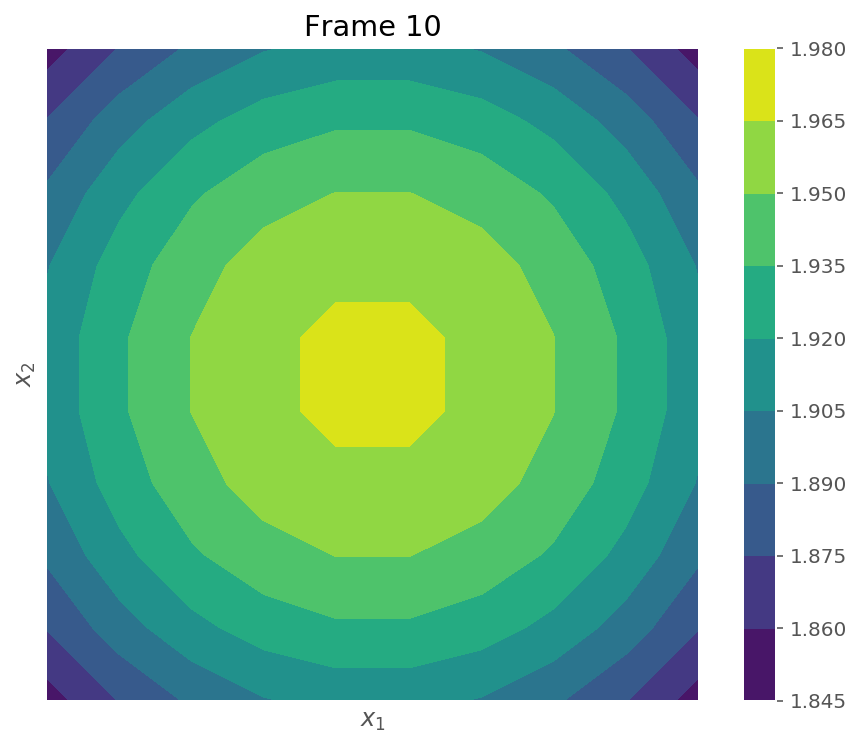

In [3]:
frame = 10

plt.figure(figsize=(8,6))
plt.subplot(111, aspect='equal')
plt.contourf(c[frame,:,:])
plt.title('Frame %2i'%frame)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

# Preparing data

Now let's prepare out data:

In [4]:
X = np.transpose(np.vstack((x1_grid.flatten(),x2_grid.flatten(),t_grid.flatten()))).astype(np.float32)
y = c.reshape((c.size),1).astype(np.float32)

In [5]:
X.dtype

dtype('float32')

and turn it into a torch tensor:

In [6]:
X_pt = torch.tensor(X, requires_grad=True)
y_pt = torch.tensor(y)

# Model 1 - No Physics informed

We have the following network geometry:

In [7]:
config = np.array([3,20,1])

We now define our model and optimizer:

In [8]:
class NeuralNet(torch.nn.Module):
    def __init__(self, NNconfig):
        super(NeuralNet, self).__init__()
        for layer in np.arange(NNconfig.shape[0]-1):
            setattr(self, 'layer'+str(layer),torch.nn.Linear(NNconfig[layer],NNconfig[layer+1]))
        self.ops = [[operation, torch.nn.ELU()] for _, operation in self.__dict__['_modules'].items()]
        self.ops = [item for sublist in self.ops for item in sublist]
        
    def forward(self, x):          
        nn = self.ops.copy()
        nn.insert(0,x)
        y_pred = reduce((lambda x,y:y(x)),nn)
            
        return y_pred

In [9]:
model = NeuralNet(config)

loss_fn = torch.nn.MSELoss()

def weights_init(m):
    torch.nn.init.xavier_uniform_(m.weight.data)

In [10]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training/ fitting

In [11]:
steps=20000

In [12]:
for i in np.arange(steps):
    y_pred = model(X_pt)

    loss = loss_fn(y_pred, y_pt)
    if i%5000==0:
        print(i, loss.item())
  
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

0 5.235202312469482
5000 0.10405006259679794
10000 0.012886135838925838
15000 0.0014483436243608594


In [13]:
c_pred = y_pred.detach().numpy().reshape(c.shape)

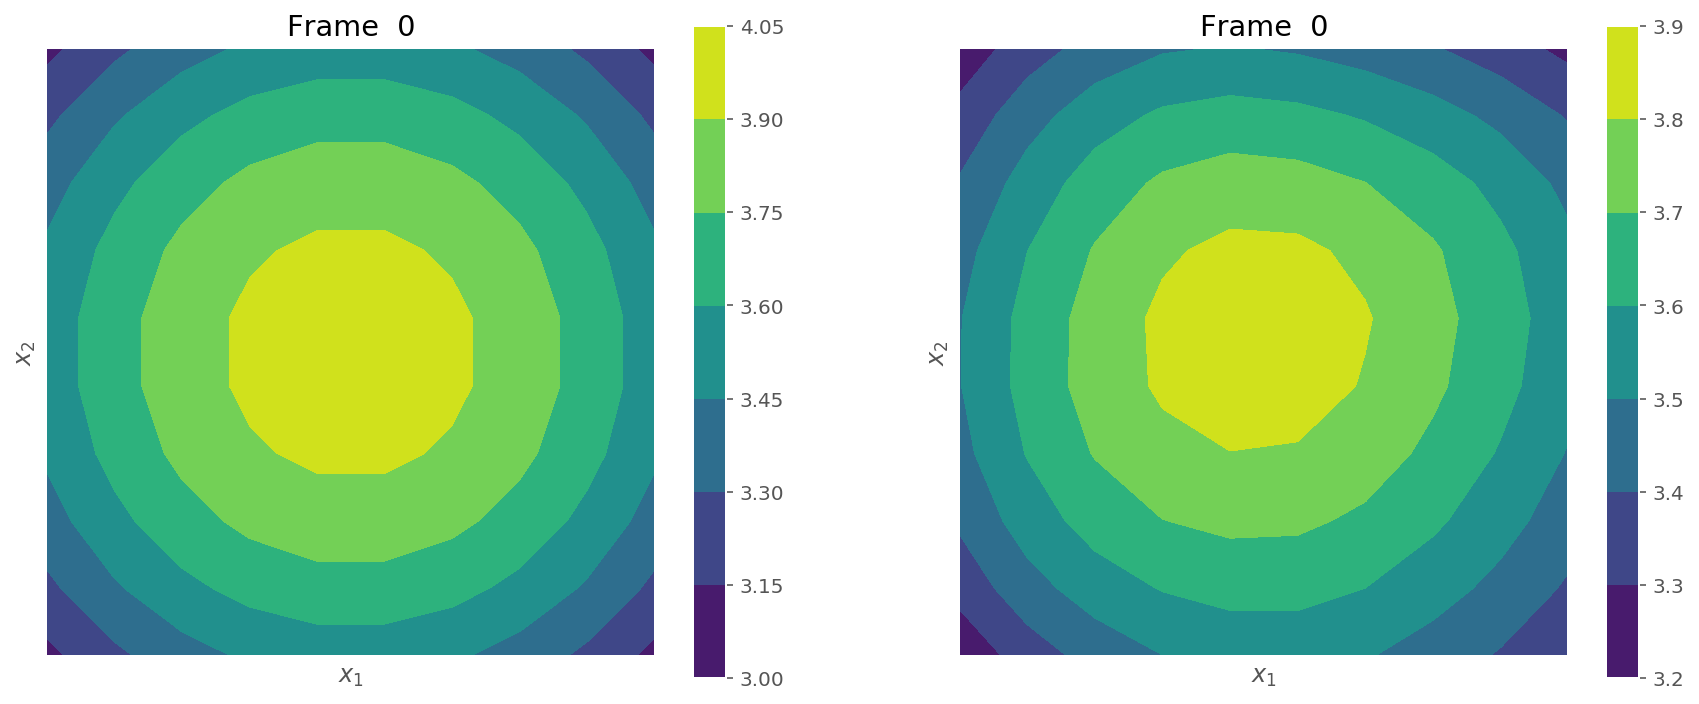

In [14]:
frame = 0

plt.figure(figsize=(15,6))

plt.subplot(121, aspect='equal')
plt.contourf(c[frame,:,:])
plt.title('Frame %2i'%frame)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.subplot(122, aspect='equal')
plt.contourf(c_pred[frame,:,:])
plt.title('Frame %2i'%frame)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.show()

In [88]:
y_pred.backward(torch.ones(3000,1))

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [15]:
grad = X_pt.grad.detach().numpy()
gradx1 = grad[:,0].reshape(c.shape)
gradx2 = grad[:,1].reshape(c.shape)
gradt = grad[:,2].reshape(c.shape)

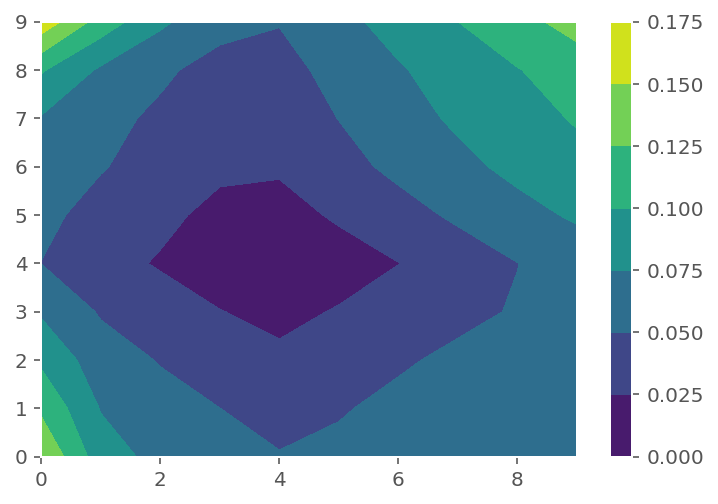

In [29]:
plt.contourf(np.abs(gradx1[10,:,:])+np.abs(gradx2[10,:,:]))
plt.colorbar()

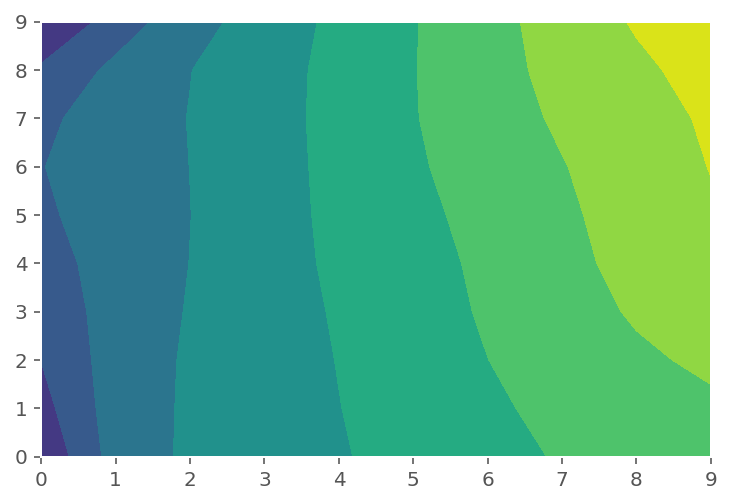

In [26]:
plt.contourf(gradx2[10,:,:])